In [ ]:
#Deteksi Sel Kanker pada Gambar Histopatologi Jaringan dengan Convolutional Neural Network


# NAMA ANGGOTA KELOMPOK 1:

# 1. HASNA SALSABILLA ABDULLAH (2502041211)
# 2. I PUTU DENIO PRANATHA RAMANANDA (2502040493)
# 3. NANDATAMA BAGUS ADISAKA (2502040524)
# 4. WILLIAM SURYADHARMA P (2502040764)
# 5. WINITA TEUKEKU PRIYANTO (2502040594)


In [2]:
#jangan run ini cuma buat download dataset
!kaggle competitions download -c histopathologic-cancer-detection --force


  0%|          | 0.00/6.31G [00:00<?, ?B/s]
  0%|          | 1.00M/6.31G [00:00<25:48, 4.37MB/s]
  0%|          | 2.00M/6.31G [00:00<17:26, 6.47MB/s]
  0%|          | 3.00M/6.31G [00:00<16:19, 6.91MB/s]
  0%|          | 4.00M/6.31G [00:00<15:04, 7.49MB/s]
  0%|          | 6.00M/6.31G [00:00<11:15, 10.0MB/s]
  0%|          | 7.00M/6.31G [00:00<11:07, 10.1MB/s]
  0%|          | 9.00M/6.31G [00:01<10:36, 10.6MB/s]
  0%|          | 11.0M/6.31G [00:01<10:39, 10.6MB/s]
  0%|          | 13.0M/6.31G [00:01<10:24, 10.8MB/s]
  0%|          | 15.0M/6.31G [00:01<12:03, 9.34MB/s]
  0%|          | 17.0M/6.31G [00:01<11:14, 10.0MB/s]
  0%|          | 18.0M/6.31G [00:01<11:17, 9.98MB/s]
  0%|          | 20.0M/6.31G [00:02<10:41, 10.5MB/s]
  0%|          | 22.0M/6.31G [00:02<10:25, 10.8MB/s]
  0%|          | 24.0M/6.31G [00:02<10:15, 11.0MB/s]
  0%|          | 26.0M/6.31G [00:02<11:10, 10.1MB/s]
  0%|          | 28.0M/6.31G [00:02<10:35, 10.6MB/s]
  0%|          | 30.0M/6.31G [00:03<10:26, 10.8MB/s]
 

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision
import torch.optim as optim
import sklearn
from sklearn.metrics import roc_auc_score, accuracy_score
from PIL import Image
import glob
import zipfile

In [2]:
temp_dir = 'input/'
print(os.listdir(temp_dir))

# Matplotlib untuk visualisasi
plt.style.use("ggplot")


['.ipynb_checkpoints', '00001b2b5609af42ab0ab276dd4cd41c3e7745b5.tif', '0000ec92553fda4ce39889f9226ace43cae3364e.tif', '00a283d23e79001ac8e765f57f0894ab89d29c59.tif', '00a2a7d5fbf50f1314a2f35e325c7cb452f4b5c8.tif', '00a8ee1938f95219182f3ec07506ec8e496b4ce3.tif', '00b0834ff7de02164bc1d58b4bf052cbe568a926.tif', '00b893ab1689e606f1fc834e51c0930c008119cd.tif', '00bdcc7806ced6afddbcffb1f79a3cf81588ccb2.tif', '00d2880985ebe7d8b6c63608f62c63c30ab1b8fa.tif', '0f9625e31eb865b803a37757c3caa50451fb898b.tif', '8acdb5485611bf3dc23f0cb6d317f199b8540d36.tif', 'c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif', 'ffc0c0b3da7bc3dae862cc2f2cef97a48261bdab.tif', 'histopathologic-cancer-detection.zip', 'sample_submission.csv', 'sample_submission_new.csv', 'test', 'train', 'train_labels.csv', 'wili-01.tif']


In [3]:
#Baca inputan yg di train_labels
full_train_df = pd.read_csv("input/train_labels.csv")
full_train_df.head()

id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

In [ ]:
#buat nge unzip, gaperlu di run lagi

# files = glob.glob('input/histopathologic-cancer-detection.zip')
# files
# for file in files:
#     print('Unzipping:',file)

#     with zipfile.ZipFile(file, 'r') as zip_ref:
#         zip_ref.extractall('input')

In [4]:
#cari tau ukuran data train sama test, awalnya test 57458 tapi wkt test cuma 50000

print("Data Train Size: {}".format(len(os.listdir('input/train/'))))
print("Data Test Size: {}".format(len(os.listdir('input/test/'))))

Data Train Size: 220025
Data Test Size: 57458


([<matplotlib.patches.Wedge at 0x1b5f2fe3760>,
 [Text(0.3233410922852413, -1.051404079333815, 'No Cancer'),
  Text(-0.3233409938456845, 1.0514041096071887, 'Cancer')],
 [Text(0.1763678685192225, -0.5734931341820809, '59.5'),
  Text(-0.1763678148249188, 0.5734931506948301, '40.5')])

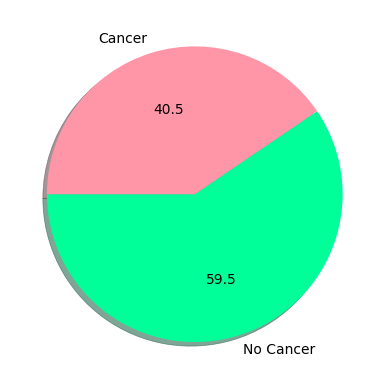

In [5]:
count = full_train_df.label.value_counts()

%matplotlib inline
plt.pie(count, labels=['No Cancer', 'Cancer'], startangle=180, autopct='%1.1f', colors=['#00ff99','#FF96A7'], shadow=True)

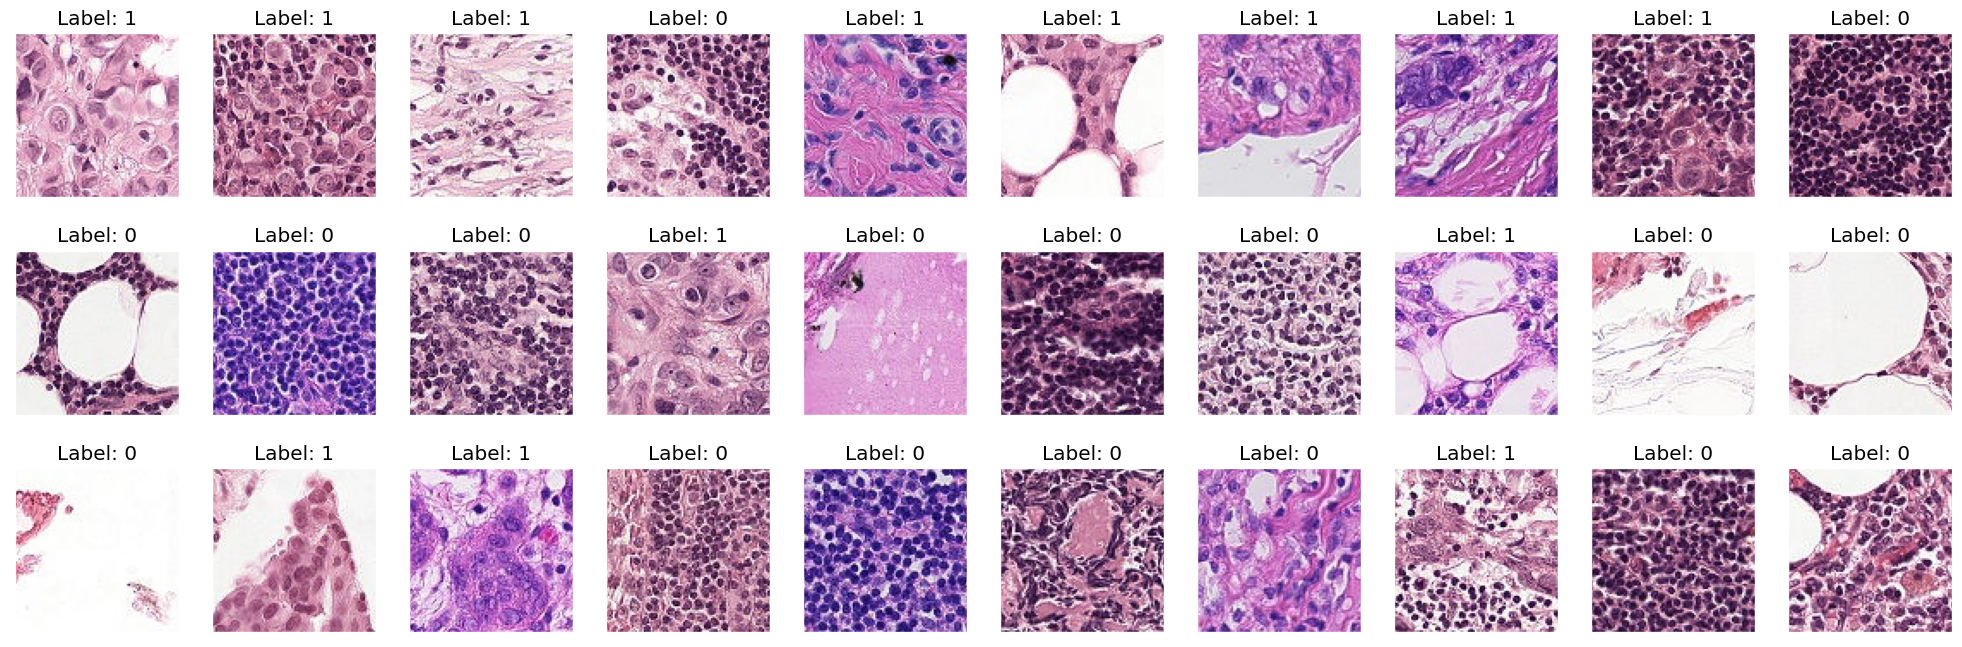

In [6]:
fig = plt.figure(figsize=(25, 8))
# display 30 images
train_imgs = os.listdir(temp_dir+"train")
for idx, img in enumerate(np.random.choice(train_imgs, 30)):
    ax = fig.add_subplot(3, 30//3, idx+1, xticks=[], yticks=[])
    im = Image.open(temp_dir+"train/" + img)
    plt.imshow(im)
    lab = full_train_df.loc[full_train_df['id'] == img.split('.')[0], 'label'].values[0]
    ax.set_title('Label: %s'%lab)

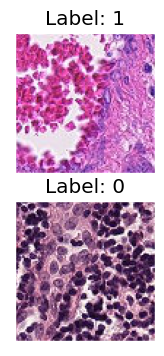

In [7]:
fig = plt.figure(figsize=(2, 4))
# display 2 images
train_imgs = os.listdir(temp_dir+"train")
for idx, img in enumerate(np.random.choice(train_imgs, 2)):
    ax = fig.add_subplot(2, 2//2, idx+1, xticks=[], yticks=[])
    im = Image.open(temp_dir+"train/" + img)
    plt.imshow(im)
    lab = full_train_df.loc[full_train_df['id'] == img.split('.')[0], 'label'].values[0]
    ax.set_title('Label: %s'%lab)

In [8]:
# jumlah sample tiap class dibagi jadi dua, 60k untuk 1 dan 60k untuk 0
sample_size = 60000
train_path = 'input/train/'
test_path = 'input/test/'
df_negatives = full_train_df[full_train_df['label'] == 0].sample(sample_size, random_state=42)
df_positives = full_train_df[full_train_df['label'] == 1].sample(sample_size, random_state=42)

# concat yg negatif sama positif terus diacak
train_df = sklearn.utils.shuffle(pd.concat([df_positives, df_negatives], axis=0).reset_index(drop=True))
train_df.shape

(120000, 2)

In [9]:
# Our own custom class for datasets
class CreateDataset(Dataset):
    def __init__(self, df_data, data_dir = './', transform=None):
        super().__init__()
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self): return len(self.df)
    
    def __getitem__(self, index):
        img_name,label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name+'.tif')
        imgage = cv2.imread(img_path)
        if self.transform is not None: image = self.transform(imgage)
        return image, label

In [11]:
transforms_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.RandomVerticalFlip(p=0.4),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = CreateDataset(df_data=train_df, data_dir=train_path, transform=transforms_train)

In [12]:
batch_size = 128

# persentase training untuk validasi
valid_size = 0.1

# train index utk validasi
num_train = len(train_data)
indices = list(range(num_train))

# split data
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# Buat Samplers
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (kombinasi dataset and sampler)
train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)

In [13]:
transforms_test = transforms.Compose([
    transforms.ToPILImage(), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) ])

# test data dibaca dari file yg baru dibuat berupa file csv yg berisi 50000 data test
sample_sub = pd.read_csv("input/sample_submission_new.csv") ###
test_data = CreateDataset(df_data=sample_sub, data_dir=train_path, transform=transforms_test) ###

# prepare test loader
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)



In [14]:
#mau jadiin data test jadi array
#ini bakal dipake di confussion matrix

sample_acs = pd.read_csv("input/sample_submission_new.csv")
label_doang = np.asarray(sample_acs['label'])
label_doang = label_doang.astype(np.float32)
label_doang = np.expand_dims(label_doang, axis=1)

print(label_doang[5])

[0.]


In [16]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        # Convolutional and Pooling Layers
        self.conv1 = nn.Sequential(
                nn.Conv2d(in_channels = 3,out_channels = 32,kernel_size = 3,stride = 1,padding = 0), #conv2d buat 2D Image Processing
                nn.BatchNorm2d(32), #normalisasi pada input untuk memiliki nilai rata-rata nol dan varian unit dan meningkatkan akurasi jaringan.
                nn.ReLU(inplace=True), #ReLU ngasih output 0 jika input negatif, jika input positif, maka output akan sama dengan input
                nn.MaxPool2d(2,2)) #engambil nilai terbesar
                
        self.conv2 = nn.Sequential(
                nn.Conv2d(in_channels = 32,out_channels = 64,kernel_size = 2,stride = 1,padding = 1),
                nn.BatchNorm2d(64), nn.ReLU(inplace = True),  nn.MaxPool2d(2,2))
        
        self.conv3 = nn.Sequential(
                nn.Conv2d(in_channels = 64,out_channels = 128,kernel_size = 3,stride = 1,padding = 1),
                nn.BatchNorm2d(128), nn.ReLU(inplace = True),  nn.MaxPool2d(2,2)) 
        
        self.conv4 = nn.Sequential(
                nn.Conv2d(in_channels = 128,out_channels = 256,kernel_size = 3,stride = 1,padding = 1),
                nn.BatchNorm2d(256),  nn.ReLU(inplace = True), nn.MaxPool2d(2,2))
        
        self.conv5 = nn.Sequential(
                nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, stride = 1, padding = 1),
                nn.BatchNorm2d(512), nn.ReLU(inplace = True), nn.MaxPool2d(2,2))
        
        self.dropout2d = nn.Dropout2d()
                
        self.fc = nn.Sequential(
                nn.Linear(512 * 3 * 3, 1024), nn.ReLU(inplace = True), nn.Dropout(0.4),
                nn.Linear(1024,512), nn.Dropout(0.4),  nn.Linear(512, 1), nn.Sigmoid())
        
    def forward(self,x):
        """Method for Forward Prop"""
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
#         print(x.shape)
        x = x.view(x.shape[0],-1)
        x = self.fc(x)
        return x

In [51]:
# check CUDA

# train_on_gpu = torch.cuda.is_available()

# if not train_on_gpu:
#     print('CUDA is not available.  Training on CPU ...')
# else:
#     print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


In [17]:
# bikin complete CNN
model = CNN()
print(model)

# Move ke GPU kalo available
# if train_on_gpu: model.cuda()

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 

In [18]:
# Trainable Parameters
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters: \n{}".format(pytorch_total_params))

Number of trainable parameters: 
6805249


In [19]:
# menentukan loss function (kategorikal cross-entropy loss)
criterion = nn.BCELoss()

# menentukan optimizer
optimizer = optim.Adam(model.parameters(), lr=0.00015) #pengoptimalan, untuk memperbarui weight network secara iteratif berdasarkan data training
#learning rate kalo di atas 0.00015 baru diperbarui

In [ ]:
#WOI INI TRAIN JANGAN DI RUN LAGI, UDAH PERNAH 28 JAM NGE TRAIN T_T

In [27]:
# jumlah iterasi
n_epochs = 30
valid_loss_min = np.Inf

#declare var
train_losses = []
valid_losses = []
val_auc = [] 
test_accuracies = []
valid_accuracies = []
auc_epoch = []

for epoch in range(1, n_epochs+1):
    train_loss = 0.0
    valid_loss = 0.0
    
    
############################################## TRAIN MODEL ####################################################################
    
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
#         if train_on_gpu:
#             data, target = data.cuda(), target.cuda().float()

        target = target.view(-1, 1)
    
        # clear gradient semua optimized variable
        optimizer.zero_grad()
        
        # forward pass: hitung prediksi output dgn passing input ke model
        output = model(data)
        target = target.to(torch.float32)
        
        # hitung batch loss
        loss = criterion(output.float(), target.float())
        
        # backward pass: hitung gradient loss
        loss.backward()
        
        # lakukan single optimization step (parameter update)
        optimizer.step()
        
        # Update Train loss dan accuracies
        train_loss += loss.item() * data.size(0)

############################################## VALIDATE MODEL ####################################################################

    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
#         if train_on_gpu:
#             data, target = data.cuda(), target.cuda().float()

        # forward pass: compute predicted outputs by passing inputs to the model
        target = target.view(-1, 1)
        output = model(data)
        target = target.to(torch.float32)
        
        # hitung the batch loss
        loss = criterion(output.float(), target.float())
        
        # update average validation loss 
        valid_loss += loss.item() * data.size(0)
        
        #output = output.topk()
        y_actual = target.data.cpu().numpy()
        y_pred = output[:,-1].detach().cpu().numpy()
        val_auc.append(roc_auc_score(y_actual, y_pred)) 
    
    # hitung rata-rata loss
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)
    valid_auc = np.mean(val_auc)
    auc_epoch.append(np.mean(val_auc))
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
        
    # print training/validation statistik
    print('Epoch: {} | Training Loss: {:.6f} | Validation Loss: {:.6f} | Validation AUC: {:.4f}'.format(
        epoch, train_loss, valid_loss, valid_auc))
    
############################################## EARLY STOP ####################################################################
    
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min, valid_loss))
        torch.save(model.state_dict(), 'best_model.pt')
        valid_loss_min = valid_loss

Epoch: 1 | Training Loss: 0.111365 | Validation Loss: 0.123500 | Validation AUC: 0.9904
Validation loss decreased (inf --> 0.123500).  Saving model ...
Epoch: 2 | Training Loss: 0.112251 | Validation Loss: 0.151206 | Validation AUC: 0.9884
Epoch: 3 | Training Loss: 0.111941 | Validation Loss: 0.128384 | Validation AUC: 0.9889
Epoch: 4 | Training Loss: 0.107997 | Validation Loss: 0.131407 | Validation AUC: 0.9889
Epoch: 5 | Training Loss: 0.106937 | Validation Loss: 0.124124 | Validation AUC: 0.9892
Epoch: 6 | Training Loss: 0.105270 | Validation Loss: 0.119186 | Validation AUC: 0.9895
Validation loss decreased (0.123500 --> 0.119186).  Saving model ...
Epoch: 7 | Training Loss: 0.103729 | Validation Loss: 0.116539 | Validation AUC: 0.9898
Validation loss decreased (0.119186 --> 0.116539).  Saving model ...
Epoch: 8 | Training Loss: 0.102782 | Validation Loss: 0.125722 | Validation AUC: 0.9898
Epoch: 9 | Training Loss: 0.100675 | Validation Loss: 0.130936 | Validation AUC: 0.9898
Epoch:

In [ ]:
#BATAS SUCI

In [18]:
#CUMA BISA DI RUN  KALO ABIS RUN TRAIN, JADINYA PAS DI RUN LAGI ERROR
#TAPI UDAH DI SS

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

NameError: name 'train_losses' is not defined

In [19]:
#CUMA BISA DI RUN  KALO ABIS RUN TRAIN, JADINYA PAS DI RUN LAGI ERROR
#TAPI UDAH DI SS


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(auc_epoch, label='Validation AUC/Epochs')
plt.legend("")
plt.xlabel("Epochs")
plt.ylabel("Area Under the Curve")
plt.legend(frameon=False)

NameError: name 'auc_epoch' is not defined

In [20]:
# cuma mau nge buka best model hasil train buat nge test data nanti

model.load_state_dict(torch.load('best_model.pt'))

<All keys matched successfully>

In [41]:
# import torch
# torch.cuda.is_available()

False

In [21]:
# Turn off gradients
model.eval()

actual = []
preds = []
k = 0

for batch_i, (data, target) in enumerate(test_loader):
    output = model(data)

    pr = output.detach().numpy()
    for i in pr:
        preds.append(i)
    
    data = np.array(data)
    for j in data:
        actual.append(j)

# Create Submission file        
sample_sub['label'] = preds

In [22]:
for i in range(len(sample_sub)):
    sample_sub.label[i] = np.float32(sample_sub.label[i])

In [23]:
sample_sub.to_csv('submission.csv', index=False)
sample_sub.head()

id             label
0  40de4dc968869fca35caf1ac69d5ad433a894b0e      [0.14824086]
1  229140c09f1b129770be1d32d4c62dcffe4c9c6e    [0.0030039488]
2  9eb4e83e01dcb57ae96471269364e4ee477f8dfd  [1.27638505e-05]
3  a2fe6d53171406d085c0eaf26e5521fc35731fd9   [1.1674623e-06]
4  0f9625e31eb865b803a37757c3caa50451fb898b       [0.9999845]

In [24]:
sample_sub.to_csv('submission.csv', index=False)
sample_sub.tail()

id            label
49995  1398e6cca867167280f88ad0fc123a70196baac2   [0.0015125307]
49996  9a566d61bcd6312f07f3f039fba1d3b40b996bde      [0.9999999]
49997  6f13c3fc985f517878deb9f900865a4385c16a47  [3.5357764e-06]
49998  7d5e0976df93ebcbb02d59f630957c7ef3d42e3a  [2.5662755e-05]
49999  d1dcd9094f4b86ad2d24d99018a4ed19807f8f9f     [0.99329937]

In [49]:
# model.load('best_model.pt')

In [25]:
def imshow(imgs):
    '''Helper function to un-normalize and display an image'''
    # unnormalize
    imgs = imgs / 2 + 0.5
    # convert from Tensor image and display
    plt.imshow(np.transpose(imgs, (1, 2, 0)))

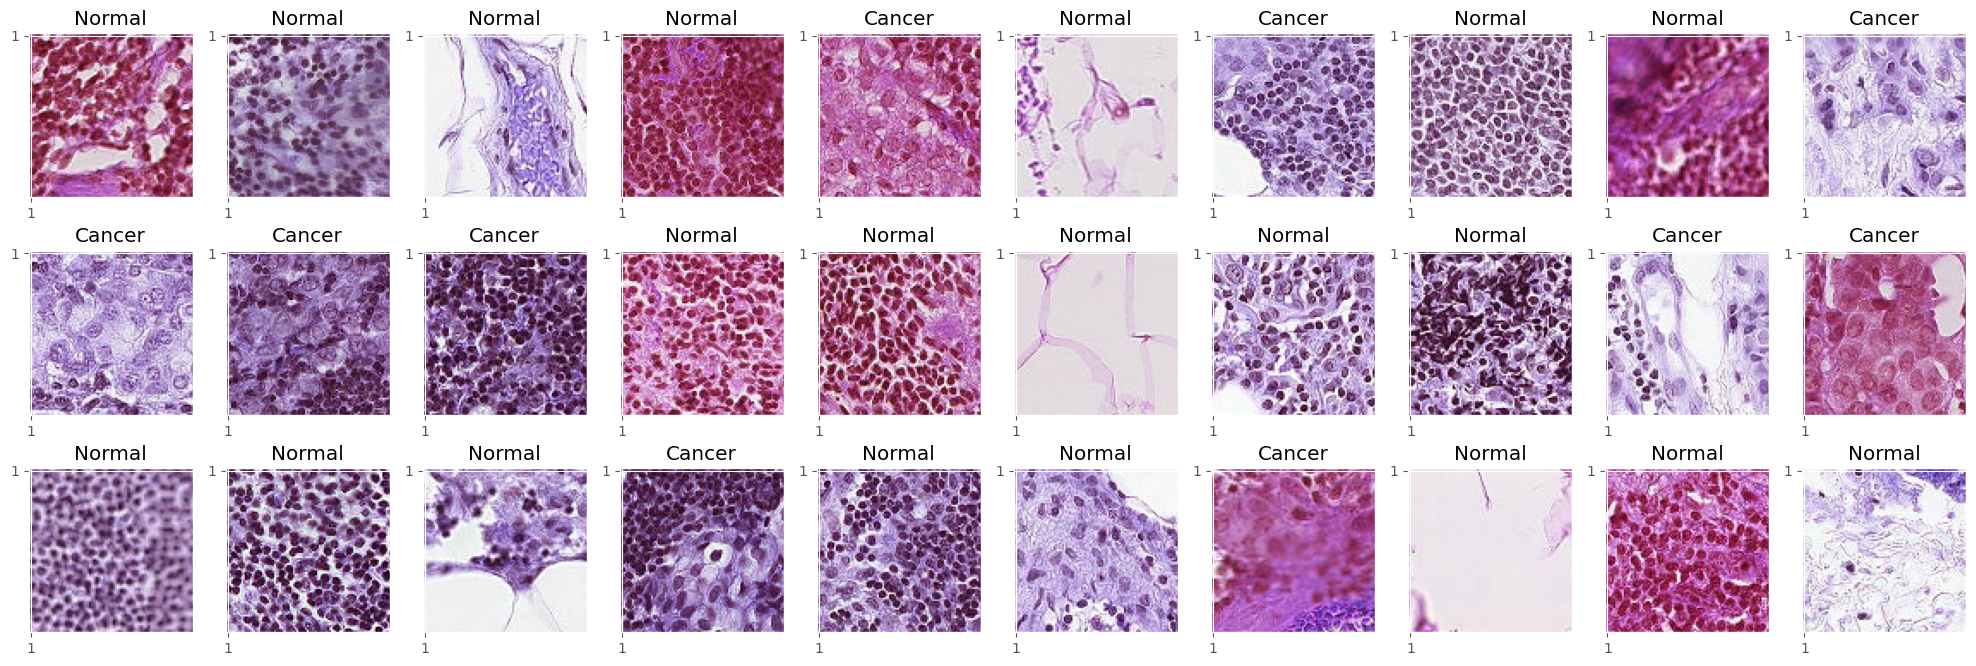

In [26]:
# obtain one batch of training images
prob = []
iterdata = iter(test_loader)
images, labels = next(iterdata)
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 8))
# display 30 images
for idx in np.arange(30):
    ax = fig.add_subplot(3, 30//3, idx+1, xticks=[1], yticks=[1])
    imshow(images[idx])
    
    if(sample_sub.label[idx] >= 0.5):
        prob = "Cancer"
    else:
        prob = "Normal" 
    ax.set_title('{}'.format(prob))

In [27]:
sample_sub.to_csv('submission.csv', index=False)
sample_sub.head(10)

id             label
0  40de4dc968869fca35caf1ac69d5ad433a894b0e      [0.14824086]
1  229140c09f1b129770be1d32d4c62dcffe4c9c6e    [0.0030039488]
2  9eb4e83e01dcb57ae96471269364e4ee477f8dfd  [1.27638505e-05]
3  a2fe6d53171406d085c0eaf26e5521fc35731fd9   [1.1674623e-06]
4  0f9625e31eb865b803a37757c3caa50451fb898b       [0.9999845]
5  c5e832e8cf519d6d79d7799b5444a89e0077ed07        [0.189925]
6  8acdb5485611bf3dc23f0cb6d317f199b8540d36       [0.9789917]
7  12dcdcdc4b6850cc15639796de8b25ae86080476   [7.7526354e-05]
8  d330699879b6e662723399e0822abb9b5504a108       [0.3793471]
9  8ad330e56bb2c36981b530c32acea2cf4ace2ebe       [0.9999676]

In [47]:
#test 1 by 1 salah  ini huhu

# from PIL import Image

# model.eval()

# preds1 = []

# img = Image.open("input/test/00dd8050f0555af5bf1b8b3ea7453c8905748a02.tif") #ganti pake dir file

# convert_tensor = transforms.ToTensor()

# output = model(convert_tensor(img))

# pr = output.detach().numpy()
# for i in pr:
# #         actual.append(full_train_df[full_train_df["id"] ]["label"])
#     preds1.append(i)

# print(preds1[0])

In [28]:
#cek jumlah yg data true sama predicted
print("label doang: {}".format(len(label_doang)))
print("Predicted: {}".format(len(preds)))

label doang: 50000
Predicted: 50000


In [29]:
arr = np.array(label_doang)
arr = np.rint(arr).astype(int)
arr = np.array(arr)
print(arr[1])

[0]


In [30]:
print(label_doang[1])
print(preds[1])

[0.]
[0.00300395]


In [31]:
arr2 = np.array(preds)
arr2 = np.rint(arr2).astype(int)
print(arr2[1])

[0]


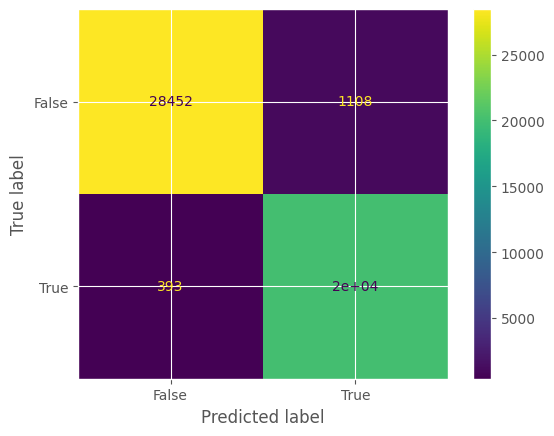

In [32]:
# Making confussion matrix
import matplotlib.pyplot as plt
import numpy
from sklearn.metrics import confusion_matrix
from sklearn import metrics

# acs = df_positives, df_negatives
acs = arr
predicted = arr2
confusion_matrix = metrics.confusion_matrix(acs, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()


In [33]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Accuracy
print('Accuracy: {}' .format(accuracy_score(acs, predicted)))

# Recall
print('Recall: {}'.format(recall_score(acs, predicted)))

# Precision
print('Precision: {}'.format(precision_score(acs, predicted)))

# F1-Score
print('F1-Score: {}'.format(f1_score(acs, predicted)))

Accuracy: 0.96998
Recall: 0.9807729941291585
Precision: 0.9476246750177263
F1-Score: 0.9639139319629763


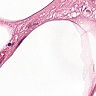

In [66]:
img = Image.open("input/00b0834ff7de02164bc1d58b4bf052cbe568a926.tif") #
img

In [67]:
convert_tensor = transforms.ToTensor()
img = convert_tensor(img)

In [68]:
preds1 = []
img = img.unsqueeze(0)
output_satuan = model(img)

pr1 = output_satuan.detach().numpy()
for i in pr1:
#         actual.append(full_train_df[full_train_df["id"] ]["label"])
    preds1.append(i)

In [69]:
preds1

[array([0.00526615], dtype=float32)]

In [70]:
if preds1[0] < 0.5:
    print("Not Cancer")
else:
    print("Cancer")

Not Cancer


In [ ]:
#At this point, tinggal tes aja


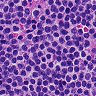

In [42]:
img2 = Image.open("input/ffc0c0b3da7bc3dae862cc2f2cef97a48261bdab.tif")
img2


In [43]:
convert_tensor = transforms.ToTensor()
img2 = convert_tensor(img2)
preds2 = []
img2 = img2.unsqueeze(0)
output_satuan = model(img2)

pr2 = output_satuan.detach().numpy()
for i in pr2:
#         actual.append(full_train_df[full_train_df["id"] ]["label"])
    preds2.append(i)
preds2
if preds2[0] < 0.5:
    print("Not Cancer")
else:
    print("Cancer")

Cancer


In [44]:
preds2

[array([0.8888215], dtype=float32)]

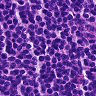

In [71]:
img3 = Image.open("input/00bdcc7806ced6afddbcffb1f79a3cf81588ccb2.tif") #input/00bdcc7806ced6afddbcffb1f79a3cf81588ccb2.tif
img3

In [72]:
convert_tensor = transforms.ToTensor()
img3 = convert_tensor(img3)
preds3 = []
img3 = img3.unsqueeze(0)
output_satuan = model(img3)

pr3 = output_satuan.detach().numpy()
for i in pr3:
#         actual.append(full_train_df[full_train_df["id"] ]["label"])
    preds3.append(i)
preds3
if preds3[0] < 0.5:
    print("Not Cancer")
else:
    print("Cancer")

Cancer


In [73]:
preds3

[array([0.86062866], dtype=float32)]

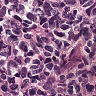

In [64]:
img4 = Image.open("") #input/00d2880985ebe7d8b6c63608f62c63c30ab1b8fa.tif
img4

In [65]:
convert_tensor = transforms.ToTensor()
img4 = convert_tensor(img4)
preds4 = []
img4 = img4.unsqueeze(0)
output_satuan = model(img4)

pr4 = output_satuan.detach().numpy()
for i in pr4:
#         actual.append(full_train_df[full_train_df["id"] ]["label"])
    preds4.append(i)
preds4
if preds4[0] < 0.5:
    print("Not Cancer")
else:
    print("Cancer")


Not Cancer


In [50]:
preds4

[array([0.00445394], dtype=float32)]

Not Cancer


[array([0.00445394], dtype=float32)]